# Oscillatory Behavior of a Simple Kinetic Model for Proteolysis during Cell Invasion


---



---



Authors: Suriya Selvarajan and Jeffery Coulter



Link for the paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1300361/

## Learning Outcomes

The goal of this notebook is to demonstrate the importance of properly scaling variables when running numerical simulations.  By the end, the user will have familiarity with
* using linear stability analysis to gain insight into system dynamics
* applying linear stability analysis to nonlinear problems
* SymPy, a symbolic algebra python package
* ensuring that simulations are scaled so as not to reach values below machine epsilon

 ## Introduction
During cellular invasion, cells undergo a highly organized pathway both in space and time to enter the extracellular space [1]. This phenomenon occurs in physiological events such as embryogenesis, as well as pathological events like inflammation and tumors. Invasion and metastasis are the results of complex interactions between cancer cells and normal stroma and are the major causes of cancer-related morbidity and mortality. Studies reveal that although millions of cells are released into the circulation each day from a primary tumor. For tumor cells to emerge from a primary mass, enter blood vessels or lymphatics, and produce a secondary growth at a distant site, they must go through a series of steps, namely: 1) invasion of the extracellular matrix (ECM) and 2) vascular dissemination, homing of tumor cells, and colonization. In the current paper published by Berry et al. they develop a simple kinetic model to describe the proteinase-dependent pathway for a cell to emigrate from its primary region into the extracellular matrix [2].










<image src="https://drive.google.com/uc?id=148vqlHOmPwwBF6AwZq4C0sokr6EneHEs" width="540">



## Background
 The structural organization and function of normal tissues is to a great extent determined by interactions between cells and the ECM. Tissues are organized into compartments separated from each other by two types of ECM: basement membrane and interstitial connective tissue. Although organized differently, each of these components of ECM is made up of collagens, glycoproteins, and proteoglycans [1]. Cells must interact with the ECM by degrading the ECM to create space, but not so much such that the cell is unable to attach to the ECM proteins, as adhesion is also required for movement.  That is, it occurs is a controlled manner.  Cells may accomplish degradation by either secreting proteolytic enzymes themselves or by inducing stromal cells (e.g., fibroblasts and inflammatory cells) to elaborate proteases. Many different families of proteases, such as matrix metalloproteinases (MMPs), etc. MMPs regulate invasion by remodeling insoluble components [1].  For adhesion, normal epithelial cells have receptors, such as integrin, for basement membrane laminin and collagens that are polarized at their basal surface; these receptors help to maintain the cells in a resting, differentiated state. Loss of adhesion in normal cells leads to induction of apoptosis while, not surprisingly, tumor cells are resistant to this form of cell death. Additionally, the matrix itself is modified in ways that promote invasion and metastasis [2]. For example, cleavage of the basement membrane proteins collagen IV and laminin by MMP2 or MMP9 generates novel sites that bind to receptors on tumor cells and stimulate migration.


## Mathematical model
Distilling the biology to a very basic situation to explain the experimental findings of oscillatory behavior in early proteolysis the Berry paper comes up with a simple, temporal mathematical model to determine whether such a simple model can replicate the controlled system of cell migration via proteinase-mediated ECM degradation.

<image src="https://drive.google.com/uc?id=1eXZSadqR1c18JrDHKLx6DL_hL3h5YaRt">




## Simulation of differential equations

This code simulates experiments performed in [2]. The equations are taken from the paper and the parameters were used as mentioned in Figure 1.


### Task 1
Find values of $k_{3}$ and $k_{4}$ (variables "k_pos3" and "k_pos4", respectively) for which the system undergoes oscillations.

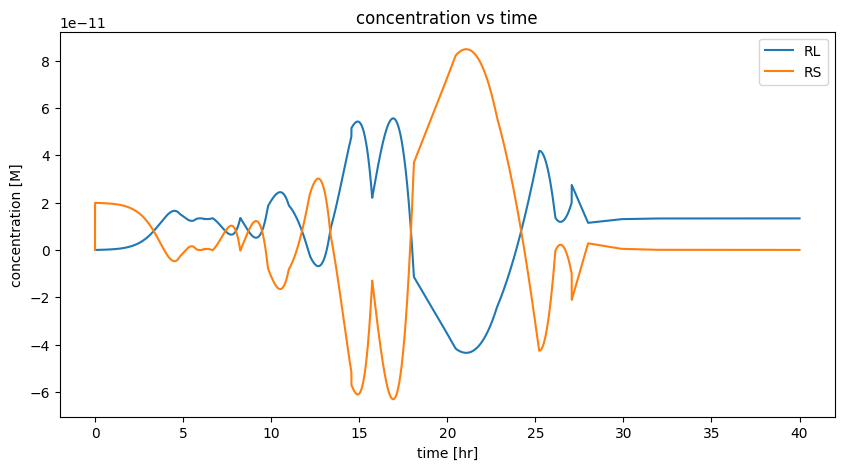

In [ ]:
from matplotlib import axes

import matplotlib.pyplot as plt                 # import plotting libraries
import numpy as np                              # import data structuring
from scipy.integrate import odeint, solve_ivp   # import ODE integrating function
import math as m                                # import math operations

# kinetic rates
K_DL = 10e-8                  # [M] dissociation constant defined as rate of dissociation over rate of association for ECM protein binding to integrin (k_neg4 / k_pos4)
K_DS = 10e-6                  # [M] dissociation constant defined as rate of dissociation over rate of association for ECM protein fragment binding to integrin (k_neg3 / k_pos3)

k_pos1 = 10e8                 # [1 / M*s] rate of association  S + E -> ES (ECM protein + proteinase -> enzyme substrate complex)
k_neg1 = 1.4e4                # [1 / s] rate of dissociation ES -> S + E (enzyme substrate complex -> ECM protein + proteinase)

k_pos2 = 110                  # [1 / s] rate of dissociation ES -> L + E (enzyme substrate complex -> ECM protein fragment + proteinase)

# specify k_pos3
k_pos3 = 1e10 #10e7           # [1 / M*s] rate of association  L + R -> RL (ECM protein fragment + integrin -> ECM protein fragment-integrin complex)
k_neg3 = K_DS * k_pos3        # [1 / s] rate of dissociation RL -> L + R (ECM protein fragment-integrin complex -> ECM protein fragment + integrin)

# specify k_pos4
k_pos4 = 1e8 #2e5             # [1 / M*s] rate of association  S + R -> RS (ECM protein + integrin -> ECM protein-integrin complex)
k_neg4 = K_DL * k_pos4        # [1 / s] rate of dissociation RS -> S + R (ECM protein-integrin complex -> ECM protein + integrin)

alpha  = 1e-1                 # [M] integrin engagement with ECM protein
beta   = 1e-1                 # [M] integrin engagement with ECM protein fragment

# initial conditions
S0  = 2e-5                    # [M] initial concentration of ECM protein
L0  = 0                       # [M] initial concentration of ECM protein fragment
E0  = 6e-11                   # [M] initial concentration of proteinase
R   = 2e-11                   # [M] concentration of integrin
ES0 = 0                       # [M] initial concentration of proteinase-ECM protein complex
RL0 = 0                       # [M] initial concentration of integrin-ECM protein fragment complex
RS0 = 0                       # [M] initial concentration of integrin-ECM protein complex

# list of initial conditions
n0 = [S0, L0, E0, ES0, RL0, RS0]

# time steps
steps = 10000
seconds = 40 * 60 * 60 # 40 hr * 60 min/hr * 60 s/min
t = np.linspace(0, seconds, steps)
t_hr = np.linspace(0, seconds/(60*60), steps)

# create function to solve ODEs
def ODEsys(n, t):
  # assign initial conditions
  S = n[0]
  L = n[1]
  E = n[2]
  ES = n[3]
  RL = n[4]
  RS = n[5]

  # define differential equations
  dSdt  = (k_neg1 * ES) - (k_pos1 * E * S)
  dLdt  = (k_pos2 * ES) + (k_neg3 * RL) - (k_pos3 * L * (R - RS - RL))
  dESdt = -((k_neg1 + k_pos2) * ES) + (k_pos1 * E * S)
  dRLdt = -(k_neg3 * RL) + (k_pos3 * L * (R - RS - RL))
  dRSdt = -(k_neg4 * RS) + (k_pos4 * S * (R - RS - RL))
  dEdt  = ((k_neg1 + k_pos2) * ES) - (k_pos1 * E * S) + (alpha * dRSdt) + (beta * dRLdt)

  return [dSdt, dLdt, dEdt, dESdt, dRLdt, dRSdt]

# ODE solution
#sol_n = solve_ivp(ODEsys, t, n0, method="RK23", rtol=1e-13, atol=1e-14) # analogue to ode23s in matlab, which was used in the paper.
                                                                         # however, it fails to converge with these parameters and will run forever
sol_n = odeint(ODEsys, n0, t)

S = sol_n[:, 0]
L = sol_n[:, 1]
E = sol_n[:, 2]
ES = sol_n[:, 3]
RL = sol_n[:, 4]
RS = sol_n[:, 5]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.set_title("concentration vs time")
ax.set_xlabel("time [hr]")
ax.set_ylabel("concentration [M]")
ax.plot(t_hr, RL, label="RL")
ax.plot(t_hr, RS, label="RS")
ax.legend()

plt.show(); # semi-colon suppresses unnecessary matplotlib output

You will notice that the concentrations of both $[RL]$ and $[RS]$ dip below zero at various times before reaching a steady state.  However, this is physically unreasonable, suggesting there is something wrong with the model.  We will now try to examine why this system of equations behaves the way that it does.

## Linear Stability Analysis

The model above produces damped oscillations, however, these oscillations lead to unphysical results such as negative concentration.  To understand why, we will use some ideas from dynamical systems theory to gain insight into qualitative aspects of a system's behavior.  Since the current model is non-linear and presents a six-dimensional vector space, a simpler two-dimensional linear problem will serve as an example to first motivate the approach.  Consider the dynamics of a damped oscillator, which may be expressed using Newton's Law as
\begin{align}
  \\
  m\ddot{x} - b\dot{x} + kx = 0
  \\
  \\
\end{align}
Here $m$ is mass, $b$ is a friction coefficient, and $k$ is a spring constant.  Since velocity may be written as $v = \dot{x}$, and since $\dot{v} = \ddot{x}$, this second-order ODE may be expressed as two coupled, first-order, differential equations,
\begin{align}
  \\
  \dot{v} &= \beta v - \omega^{2} x
  \\
  \dot{x} &= v
  \\
  \\
\end{align}
where $\beta = \frac{b}{m}$ and $\omega^{2} = \frac{k}{m}$.  The two equations above may be written in matrix-vector form as follows
\begin{align}
        \\
        \begin{pmatrix}
          \dot{v} \\
          \dot{x}
        \end{pmatrix} = \begin{pmatrix}
                        \beta & -\omega^{2} \\
                        1 & 0
                        \end{pmatrix}
                        \begin{pmatrix}
                        v \\
                        x
                        \end{pmatrix}
        \\
        \\
\end{align}
When trying to qualitatively describe a dynamical system, one would like to find basis vectors along which only one variable is changing.  These basis vectors represent special trajectories called "straight-line trajectories" and are important since trajectories in phase space can never cross. That is, these special trajectories set up "boundaries" along which other trajectories must agree with.  It turns out that these straight-line trajectories occur along the eigenvectors of the matrix which maps variables to their derivatives.  In our case, we want the eigenvectors of
\begin{align}
  \\
  \begin{pmatrix}
  \beta & -\omega^{2} \\
  1 & 0
  \end{pmatrix}
  \\
  \\
\end{align}
To do so, we need the eigenvalues, which are
\begin{align}
  \\
  \lambda_{1,2} = \frac{\beta \pm \sqrt{\beta^{2} - 4\omega^{2}}}{2}
  \\
  \\
\end{align}
First, there are two things to note.  The eigenvalues may be expressed in terms of the trace and determinant of the matrix, namely, if $\tau$ is the trace and $\Delta$ is the determinant, then
\begin{align}
  \\
  \lambda_{1,2} = \frac{\tau \pm \sqrt{\tau^{2} - 4\Delta}}{2}
  \\
  \\
\end{align}
Furthermore, there is no physical reason requiring that $\beta^{2} > 4\omega^{2}$, and so it is possible that $\beta^{2} - 4\omega^{2} < 0$, which means that the eigenvalues will be complex.  It turns out that, for our purposes, this is sufficient to gain qualitative insight into the dynamics of the system and determine whether it can oscillate.  Assuming that $\beta^{2} < 4\omega^{2}$, or $\tau^{2} < 4\Delta$, we can write the eigenvalues $\lambda_{1,2}$ as complex numbers
\begin{align}
  \\
  \lambda_{1,2} = a \pm ib
  \\
  \\
\end{align}
where $a = \frac{\tau}{2}$ and $b = \frac{\sqrt{\tau^{2} - 4\Delta}}{2} \neq 0$.  Considering the real part of $\lambda_{1,2}$, that is, $\Re(\lambda_{1,2}) = a$, we have three cases.  If $a = 0$, then the system would undergo periodic orbits in phase space, or periodic oscillations in phase space.  This makes sense because, in our case, it corresponds to $\beta = 0$, or the oscillator is undamped.  If $a < 0$, then this corresponds to $\beta < 0$, which leads to spirals eventually converging to a fixed point in phase space, or damped oscillations in physical space.  The final case $a > 0$ corresponds to growing oscillations.  Since this is not meant to serve as a complete course in dynamical systems, we will now move on to apply the above approach to the model from the paper to determine whether or not the proposed system is capable of oscillating.  In general, the sign of the trace $\tau$ determines whether the solution will be a source $(\tau > 0)$ or sink $(\tau < 0)$, while the difference $\tau^{2} - 4\Delta$ determines whether spirals exist (which is true for complex eigenvalues, i.e. $\tau^{2} < 4\Delta)$. For a more thorough treatment of why this is true, see e.g. *Nonlinear Dynamics and Chaos* by Strogatz or, for more biological perspectives, *Mathematical Biology* by Murray and *Dynamical Systems in Neuroscience* by Izhikevich [3, 4,5].  The plots below demonstrate how $\tau$ can be used to determine system dynamics.  The red circles in the phase portraits represent the initial conditions.



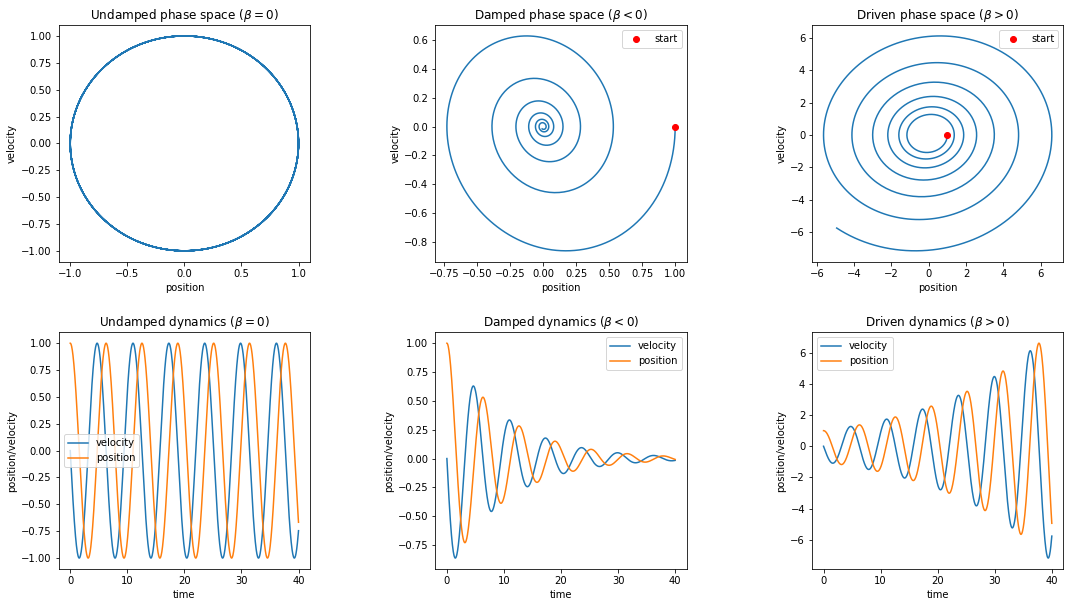

In [ ]:
# demonstration of how beta determines oscillatory behavior

# initial conditions and time steps
v0 = 0
x0 = 1
n0 = [v0, x0]
t = np.linspace(0, 40, 1000)

def Spring(v, x, beta, omega):
  '''
  function describing the dynamics of a spring with possible damped or driven oscillations
    v: initial velocity
    x: initial position
    beta: damping or driving coefficient divided by mass
    omega: spring constant divided by mass
  '''
  dvdt = beta * v - x * np.power(omega, 2)
  dxdt = v

  return [dvdt, dxdt]

# functions for undamped, damped and driven oscillations to be used with odeint
def SpringUndamped(n, t):
  omega = 1
  beta = 0

  v = n[0]
  x = n[1]

  return Spring(v, x, beta, omega)

def SpringDamped(n, t):
  omega = 1
  beta = -0.2

  v = n[0]
  x = n[1]

  return Spring(v, x, beta, omega)

def SpringDriven(n, t):
  omega = 1
  beta = 0.1

  v = n[0]
  x = n[1]

  return Spring(v, x, beta, omega)

sol_undamped = odeint(SpringUndamped, n0, t)
sol_damped = odeint(SpringDamped, n0, t)
sol_driven = odeint(SpringDriven, n0, t)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
#fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.5)

# undamped phase portrait and dynamics plots
ax[0][0].set_title(r"Undamped phase space $\left( \beta = 0 \right)$")
ax[0][0].set_xlabel("position")
ax[0][0].set_ylabel("velocity")
ax[0][0].plot(sol_undamped[:, 1], sol_undamped[:, 0])
ax[1][0].set_title(r"Undamped dynamics $\left( \beta = 0 \right)$")
ax[1][0].set_xlabel("time")
ax[1][0].set_ylabel("position/velocity")
ax[1][0].plot(t, sol_undamped[:, 0], label="velocity")
ax[1][0].plot(t, sol_undamped[:, 1], label="position")
ax[1][0].legend()

# damped phase portrait and dynamics plots
ax[0][1].set_title(r"Damped phase space $\left( \beta < 0 \right)$")
ax[0][1].set_xlabel("position")
ax[0][1].set_ylabel("velocity")
ax[0][1].plot(sol_damped[:, 1], sol_damped[:, 0])
ax[0][1].plot(sol_damped[0, 1], sol_damped[0, 0], color="red", marker="o", linestyle="none", label="start")
ax[0][1].legend()
ax[1][1].set_title(r"Damped dynamics $\left( \beta < 0 \right)$")
ax[1][1].set_xlabel("time")
ax[1][1].set_ylabel("position/velocity")
ax[1][1].plot(t, sol_damped[:, 0], label="velocity")
ax[1][1].plot(t, sol_damped[:, 1], label="position")
ax[1][1].legend()

# driven phase portrait and dynamics plots
ax[0][2].set_title(r"Driven phase space $\left( \beta > 0 \right)$")
ax[0][2].set_xlabel("position")
ax[0][2].set_ylabel("velocity")
ax[0][2].plot(sol_driven[:, 1], sol_driven[:, 0])
ax[0][2].plot(sol_driven[0, 1], sol_driven[0, 0], color="red", marker="o", linestyle="none", label="start")
ax[0][2].legend()
ax[1][2].set_title(r"Driven dynamics $\left( \beta > 0 \right)$")
ax[1][2].set_xlabel("time")
ax[1][2].set_ylabel("position/velocity")
ax[1][2].plot(t, sol_driven[:, 0], label="velocity")
ax[1][2].plot(t, sol_driven[:, 1], label="position")
ax[1][2].legend()

plt.show();

## Converting a non-linear problem to a linear problem

As mentioned above, the model from the paper is a nonlinear dynamical system.  However, the linear stability tactics just described may still be used by approximating the nonlinear equations as linear.  This is accomplished by applying a Taylor series expansion.  For example, for a function $f(x,y)$, this would be

\begin{align}
  \\
  f(x, y) = f(x_{0},y_{0}) + \delta_{x}\dfrac{\partial f}{\partial x} +
                            \delta_{y}\dfrac{\partial f}{\partial y} +
                            O^{2}
\\
\\
\end{align}

Here $\delta_{x} = x - x_{0}$, $\delta_{y} = y - y_{0}$, and $O^{2} = O\left(\delta_{x}^{2}, \delta_{y}^{2}, \delta_{x}\delta_{y}\right)$ represents the nonlinear terms of quadratic order and higher. By dropping these terms, we obtain a linearized form of $f(x,y)$.

&emsp; Going back to our original system $\left( S, L, E, ES, RS, RL \right)$, but without the integrin terms $R$ or fragment terms $L$, we have a system $\left( S, E, ES \right)$ given by
\begin{align}
  \\
  \dot{S} &= f_{S}(S, E, ES) = ES - E \cdot S
  \\
  \dot{E} &= f_{E}(S, E, ES) = ES - E \cdot S
  \\
  \dot{ES} &= f_{ES}(S, E, ES) = -ES + E \cdot S
  \\
  \\
\end{align}
where the rate constants have been removed to reduce clutter.  This is a simplified model describing the kinetics of proteinase $E$ binding to ECM proteins $S$.  To linearize this system, we need a point around which to expand the functions $f_{S}$, $f_{E}$ and $f_{ES}$ as a Taylor series.  Since we are interested in the dynamics of the system, we will use equilibrium points $(S^{*}, E^{*}, ES^{*})$ such that
\begin{align}
  \\
  f_{S}(S^{*}, E^{*}, ES^{*}) =
  f_{E}(S^{*}, E^{*}, ES^{*}) =
  f_{ES}(S^{*}, E^{*}, ES^{*}) = 0
  \\
  \\
\end{align}
By defining the variables $\delta_{S} = S - S^{*}$, $\delta_{E} = E - E^{*}$, and $\delta_{ES} = ES - ES^{*}$, we can see that
\begin{align}
  \\
  \dot{\delta}_{S} &= \dot{S} = f_{S}(S, E, ES)
  \\
  \dot{\delta}_{E} &= \dot{E} = f_{E}(S, E, ES)
  \\
  \dot{\delta}_{ES} &= \dot{ES} = f_{ES}(S, E, ES)
  \\
  \\
\end{align}
We can then expand these functions around the equilibrium point $(S^{*}, E^{*}, ES^{*})$ as
\begin{align}
  \\
  \dot{\delta}_{S} &= f_{S}(S^{*} + \delta_{S}, E^{*} + \delta_{E}, ES^{*} + \delta_{ES})
  \\
  &= f_{S}(S^{*}, E^{*}, ES^{*}) + \delta_{S}\dfrac{\partial f_{S}}{\partial S} + \delta_{E}\dfrac{\partial f_{S}}{\partial E} + \delta_{ES}\dfrac{\partial f_{S}}{\partial ES} + O^{2}
  \\
  &= \delta_{S}\dfrac{\partial f_{S}}{\partial S} + \delta_{E}\dfrac{\partial f_{S}}{\partial E} + \delta_{ES}\dfrac{\partial f_{S}}{\partial ES} + O^{2}
  \\
  \\
  \dot{\delta}_{E} &= f_{E}(S^{*} + \delta_{S}, E^{*} + \delta_{E}, ES^{*} + \delta_{ES})
  \\
  &= f_{E}(S^{*}, E^{*}, ES^{*}) + \delta_{S}\dfrac{\partial f_{E}}{\partial S} + \delta_{E}\dfrac{\partial f_{E}}{\partial E} + \delta_{ES}\dfrac{\partial f_{E}}{\partial ES} + O^{2}
  \\
  &= \delta_{S}\dfrac{\partial f_{E}}{\partial S} + \delta_{E}\dfrac{\partial f_{E}}{\partial E} + \delta_{ES}\dfrac{\partial f_{E}}{\partial ES} + O^{2}
  \\
  \\
  \dot{\delta}_{ES} &= f_{ES}(S^{*} + \delta_{S}, E^{*} + \delta_{E}, ES^{*} + \delta_{ES})
  \\
  &= f_{ES}(S^{*}, E^{*}, ES^{*}) + \delta_{S}\dfrac{\partial f_{ES}}{\partial S} + \delta_{E}\dfrac{\partial f_{ES}}{\partial E} + \delta_{ES}\dfrac{\partial f_{ES}}{\partial ES} + O^{2}
  \\
  &= \delta_{S}\dfrac{\partial f_{ES}}{\partial S} + \delta_{E}\dfrac{\partial f_{ES}}{\partial E} + \delta_{ES}\dfrac{\partial f_{ES}}{\partial ES} + O^{2}
  \\
  \\
  \\
\end{align}
where it is understood that each derivative is evaluated at the equilibrium point $(S^{*}, E^{*}, ES^{*})$.  Assuming that the $\delta$ terms are small deviations from the equilibrium points, then $O^{2}$ is neglibile and the above system can be expressed as a matrix equation analogous to the linear case
\begin{align}
        \\
        \begin{pmatrix}
          \dot{\delta}_{S} \\
          \\
          \dot{\delta}_{E} \\
          \\
          \dot{\delta}_{ES}
        \end{pmatrix} = \begin{pmatrix}
                        \dfrac{\partial f_{S}}{\partial S} & \dfrac{\partial f_{S}}{\partial E} & \dfrac{\partial f_{S}}{\partial ES} \\
                        \dfrac{\partial f_{E}}{\partial S} & \dfrac{\partial f_{E}}{\partial E} & \dfrac{\partial f_{E}}{\partial ES} \\
                        \dfrac{\partial f_{ES}}{\partial S} & \dfrac{\partial f_{ES}}{\partial E} & \dfrac{\partial f_{ES}}{\partial ES} \\
                        \end{pmatrix}
                        \begin{pmatrix}
                        \delta_{S} \\
                        \\
                        \delta_{E} \\
                        \\
                        \delta_{ES}
                        \end{pmatrix}
        \\
        \\
\end{align}
where the transformation matrix is known as the Jacobian.  From here, the same analysis that was used in the linear case can be applied to study the system.

### Task 2
Use the Python package SymPy to symbolically solve for the full system's (including integrin $R$ and fragment $L$ terms) equilibrium points.  You can neglect the kinetic rate constants since they will essentially only scale the final result and won't impact the behavior of the system for our purposes.  However, if you were to consider other situations, such as bifurcations, these constants should be left in the equations.

In [ ]:
# linear stability analysis
import sympy as sm

# use the sympy.symbols function to declare symbolic variables for the six variables in the paper's model
# this sets the concentration to symbols rather than numerical values for algebraic manipulations
S, L, E, ES, RL, RS = sm.symbols("S, L, E, ES, RL, RS")

# write the differential equations in terms of these variables. you can ignore the reaction constants and
# just include the system variables
dSdt  = (ES) - (E * S)
dLdt  = (ES) + (RL) - (L * (1 - RS - RL))
dESdt = -(ES) + (E * S)
dRLdt = -(RL) + (L * (1 - RS - RL))
dRSdt = -(RS) + (S * (1 - RS - RL))
dEdt  = (ES) - (E * S)

# set the symbolic ODEs to 0 using the sympy.Eq function
dSdt_eq = sm.Eq(dSdt, 0)
dLdt_eq = sm.Eq(dLdt, 0)
dESdt_eq = sm.Eq(dESdt, 0)
dRLdt_eq = sm.Eq(dRLdt, 0)
dRSdt_eq = sm.Eq(dRSdt, 0)
dEdt_eq = sm.Eq(dEdt, 0)

# solve for stationary points using the sympy.solve function
equilibria = sm.solve((dSdt_eq, dLdt_eq, dESdt_eq, dRLdt_eq, dRSdt_eq, dEdt_eq), S, L, ES, RL, RS, E)
print(equilibria)

[(S, L, 0, L/(L + S + 1), S/(L + S + 1), 0), (0, L, 0, L/(L + 1), 0, E)]


### Task 3

Using SymPy, compute the Jacobian matrix of the system of equations.

In [ ]:
# use the sympy.diff function to construct the jacobian matrix. this should be a 6x6 matrix.
jacobian = [[sm.diff(dSdt,  S), sm.diff(dSdt,  L), sm.diff(dSdt,  ES), sm.diff(dSdt,  RL), sm.diff(dSdt,  RS), sm.diff(dSdt, E)],
            [sm.diff(dLdt,  S), sm.diff(dLdt,  L), sm.diff(dLdt,  ES), sm.diff(dLdt,  RL), sm.diff(dLdt,  RS), sm.diff(dLdt, E)],
            [sm.diff(dESdt, S), sm.diff(dESdt, L), sm.diff(dESdt, ES), sm.diff(dESdt, RL), sm.diff(dESdt, RS), sm.diff(dESdt, E)],
            [sm.diff(dRLdt, S), sm.diff(dRLdt, L), sm.diff(dRLdt, ES), sm.diff(dRLdt, RL), sm.diff(dRLdt, RS), sm.diff(dRLdt, E)],
            [sm.diff(dRSdt, S), sm.diff(dRSdt, L), sm.diff(dRSdt, ES), sm.diff(dRSdt, RL), sm.diff(dRSdt, RS), sm.diff(dRSdt, E)],
            [sm.diff(dEdt,  S), sm.diff(dEdt,  L), sm.diff(dEdt,  ES), sm.diff(dEdt,  RL), sm.diff(dEdt,  RS), sm.diff(dEdt, E)]]

# see: https://stackoverflow.com/questions/13214809/pretty-print-2d-list
s = [[str(e) for e in row] for row in jacobian]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print('\n'.join(table))

-E          	0           	1 	0     	0     	-S
0           	RL + RS - 1 	1 	L + 1 	L     	0 
E           	0           	-1	0     	0     	S 
0           	-RL - RS + 1	0 	-L - 1	-L    	0 
-RL - RS + 1	0           	0 	-S    	-S - 1	0 
-E          	0           	1 	0     	0     	-S


In Task 2, you should have found that there are infinitely many depending on the values of two variable.  Which two variables are they?  Specify the two variables which define an equilibrium state and compute the trace and determinant of the Jacobian at that point.

In [ ]:
# write the variables as their stationary values
S_eq = 100
RS_eq = 10
L_eq = -S_eq - 1 + (S_eq / RS_eq)
E_eq = 0
ES_eq = 0
RL_eq = -RS_eq - (RS_eq/S_eq) + 1

# fill in jacobian matrix using these values
jacobian = np.asarray([[-E_eq,              0,                  1,  0,         0,         -S_eq ],
                       [0,                  RL_eq + RS_eq - 1,  1,  L_eq + 1,  L_eq,      0     ],
                       [E_eq,               0,                  -1, 0,         0,         S_eq  ],
                       [0,                  -RL_eq - RS_eq + 1, 0,  -L_eq - 1, -L_eq,     0     ],
                       [-RL_eq - RS_eq + 1, 0,                  0,  -S_eq,     -S_eq - 1, 0     ],
                       [-E_eq,              0,                  1,  0,         0,         -S_eq]])

# compute the trace and determinant using numpy.trace and numpy.linalg.det, respectively
tr = np.trace(jacobian)
det = np.linalg.det(jacobian) # equals 0 -> an eigenvalue is 0 -> no spirals in phase space -> no oscillations

print("the trace of the jacobian is", tr)
print("the determinant of the jacobian is", det)

the trace of the jacobian is -112.1
the determinant of the jacobian is 0.0


Recall that in order to achieve oscillations, we require that the eigenvalues be complex which occurs when $\tau^{2} < 4\Delta$. However, here we have $\Delta = 0$.  Since the determinant is the product of the eigenvalues, this implies that at least one of the eigenvalues are zero.  That is, there is an eigenvector, or "straight-line trajectory", along which the solutions are constants, or fixed points.  Since these trajectories define a type of "boundary" as described before, then solutions nearby will either converge to it or diverge from it, depending on the sign of $\tau$.  Therefore, there are no spirals in phase space and thus oscillations cannot occur in this system.

## Scaling up the parameters

If this system can't oscillate, how did we the observe oscillations above?  Looking at the terms in, for instance, $\left[ \dot{RS}\right]$, which is almost alway negative, we have $[S][R] \propto 10^{-17}$.  However, looking at the machine epsilon, or the upper bound on approximation error in floating point arithmetic, we have

In [ ]:
np.finfo(float).eps

2.220446049250313e-16

This is larger than $[S][R]$! Therefore, the model with the parameters scaled as they are, at the pico- or micro-molar scale, reaches values which are too small for the computer to accurately work with.  To see how the model would behave while computing in an appropriate numerical range, we have to rescale the parameters.

### Task 4

Scale the parameters by a nano-molar factor an re-run the simulation.

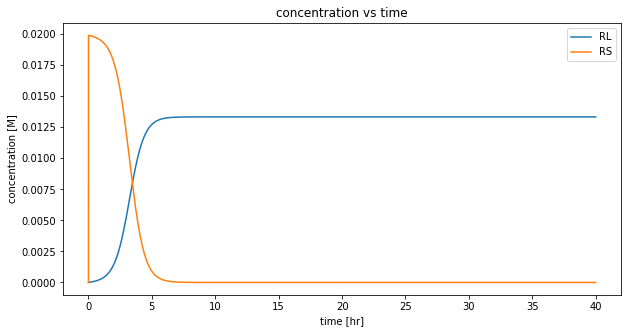

In [ ]:
from matplotlib import axes

import matplotlib.pyplot as plt                 # import plotting libraries
import numpy as np                              # import data structuring
from scipy.integrate import odeint, solve_ivp   # import ODE integrating function
import math as m                                # import math operations

# kinetic rates
K_DL = 10e1                   # [nM] dissociation constant defined as rate of dissociation over rate of association for ECM protein binding to integrin (k_neg4 / k_pos4)
K_DS = 10e3                   # [nM] dissociation constant defined as rate of dissociation over rate of association for ECM protein fragment binding to integrin (k_neg3 / k_pos3)

k_pos1 = 10e-1                # [1 / nM*s]  rate of association  S + E -> ES (ECM protein + proteinase -> enzyme substrate complex)
k_neg1 = 1.4e4                # [1 / s]    rate of dissociation ES -> S + E (enzyme substrate complex -> ECM protein + proteinase)

k_pos2 = 110                  # [1 / s]    rate of dissociation ES -> L + E (enzyme substrate complex -> ECM protein fragment + proteinase)

k_pos3 = 1e1                  # [1 / nM*s] rate of association  L + R -> RL (ECM protein fragment + integrin -> ECM protein fragment-integrin complex)
k_neg3 = K_DS * k_pos3        # [1 / s]   rate of dissociation RL -> L + R (ECM protein fragment-integrin complex -> ECM protein fragment + integrin)

k_pos4 = 1e-1 #2e5            # [1 / nM*s] rate of association  S + R -> RS (ECM protein + integrin -> ECM protein-integrin complex)
k_neg4 = K_DL * k_pos4        # [1 / s]   rate of dissociation RS -> S + R (ECM protein-integrin complex -> ECM protein + integrin)

alpha  = 1e-1                  # [nM] integrin engagement with ECM protein
beta   = 1e-1                  # [nM] integrin engagement with ECM protein fragment

# initial conditions
S0  = 2e4                     # [nM] initial concentration of ECM protein
L0  = 0                       # [nM] initial concentration of ECM protein fragment
E0  = 6e-2                    # [nM] initial concentration of proteinase
R   = 2e-2                    # [nM] concentration of integrin
ES0 = 0                       # [nM] initial concentration of proteinase-ECM protein complex
RL0 = 0                       # [nM] initial concentration of integrin-ECM protein fragment complex
RS0 = 0                       # [nM] initial concentration of integrin-ECM protein complex

# list of initial conditions
n0 = [S0, L0, E0, ES0, RL0, RS0]

# time steps
steps = 10000
seconds = 40 * 60 * 60 # 10 hr * 60 min/hr * 60 s/min
t = np.linspace(0, seconds, steps)
t_hr = np.linspace(0, seconds/(60*60), steps)

# create function to solve ODEs
def ODEsys(n, t):
  # assign initial conditions
  S = n[0]
  L = n[1]
  E = n[2]
  ES = n[3]
  RL = n[4]
  RS = n[5]

  # define differential equations
  dSdt  = (k_neg1 * ES) - (k_pos1 * E * S)
  dLdt  = (k_pos2 * ES) + (k_neg3 * RL) - (k_pos3 * L * (R - RS - RL))
  dESdt = -((k_neg1 + k_pos2) * ES) + (k_pos1 * E * S)
  dRLdt = -(k_neg3 * RL) + (k_pos3 * L * (R - RS - RL))
  dRSdt = -(k_neg4 * RS) + (k_pos4 * S * (R - RS - RL))
  dEdt  = ((k_neg1 + k_pos2) * ES) - (k_pos1 * E * S) + (alpha * dRSdt) + (beta * dRLdt)

  return [dSdt, dLdt, dEdt, dESdt, dRLdt, dRSdt]

# ODE solution
#sol_n = solve_ivp(ODEsys, t, n0, method="RK23", rtol=1e-13, atol=1e-14) # analogue to ode23s in matlab, which was used in the paper.
                                                                         # however, it fails to converge with these parameters and will run forever
sol_n = odeint(ODEsys, n0, t)

S = sol_n[:, 0]
L = sol_n[:, 1]
E = sol_n[:, 2]
ES = sol_n[:, 3]
RL = sol_n[:, 4]
RS = sol_n[:, 5]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.set_title("concentration vs time")
ax.set_xlabel("time [hr]")
ax.set_ylabel("concentration [M]")
ax.plot(t_hr, RL, label="RL")
ax.plot(t_hr, RS, label="RS")
ax.legend()

plt.show(); # semi-colon suppresses unnecessary matplotlib output

REFERENCES:
1.	Kumar, V., Abbas, A. K., & Aster, J. C. (2015). Robbins and Cotran pathologic basis of disease Elsevier/Saunders.
2. Hugues Berry and V ́eronique Larreta-Garde. Oscillatory behavior of a simple kinetic model for proteolysis
during cell invasion. Biophysical journal, 77:655–665, 1999. https://www.cell.com/biophysj/fulltext/S0006-3495(99)76921-3
3. Strogatz, Steven. Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering. CRC Press, 2019.
4. Murray, J. D. Mathematical Biology. Springer-Verlag, 2003.
5. Izhikevich, Eugene M. Dynamical Systems in Neuroscience: The Geometry of Excitability and Bursting. MIT Press, 2014.